In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True
from scipy import stats
import pastas as ps
#ps.set_log_level("INFO")
ps.show_versions()

import logging, sys
logging.disable(sys.maxsize)

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.2
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0
LMfit version: 1.3.1
Latexify version: Not Installed
Pastas version: 1.5.0


Definition of the extremes of calibration and validation periods according to the Groundwater Challenge instructions.  
- Calibration period: data used to fit the model.  
- Validation period: data used to test the model's predictive performance.

In [2]:
tmin_cal = "2002-05-01"
tmax_cal = "2016-12-31"
tmin_val = "2017-01-01"
tmax_val = "2021-12-31"

Importing the data.  
- `head`: Time series data of observed groundwater head levels, loaded from a CSV file.
- `stresses`: Time series data of various stressors, loaded from a CSV file.
Data is indexed by dates for time series analysis.  
This specific stresses dataset includes: 
- Precipitation data stored in the `prec` variable in [mm/day].
- River stage data stored in the `river` variable in [m].
- Evaporation data stored in the `evap` variable in [mm/day].  
Two different head datasets are provided, they are both imported, nonetheless, they are the exact same and cover the totality of the avaiable head observations.  
Using the complete head observations dataset, two subsets are created, one covering the calibration period (`head_cal`) and one covering the validation period (`head_val`).

In [3]:
path_head = "data/heads.csv"
path_stresses = "data/input_data.csv"

In [4]:
head = pd.read_csv(path_head, index_col=0, parse_dates=True).squeeze()
heads_full = head = pd.read_csv("data/heads_full.csv", index_col=0, 
                       parse_dates=True).squeeze()

stresses = pd.read_csv(path_stresses, index_col=0, parse_dates=True).squeeze()
prec = stresses.iloc[:, 0].rename("prec").dropna()
evap = stresses.iloc[:, 8].rename("evap").dropna()

In [5]:
head_cal = head[(head.index >= tmin_cal) & (head.index <= tmax_cal)]
head_val = heads_full[(heads_full.index >= tmin_val) & (heads_full.index <= tmax_val)]

This plot provides a summary of the observed groundwater head levels and stressors over time.  
The visualization helps identify trends and patterns before model fitting, as well as getting a first idea of the order of magnitude of the head levels and stressors.

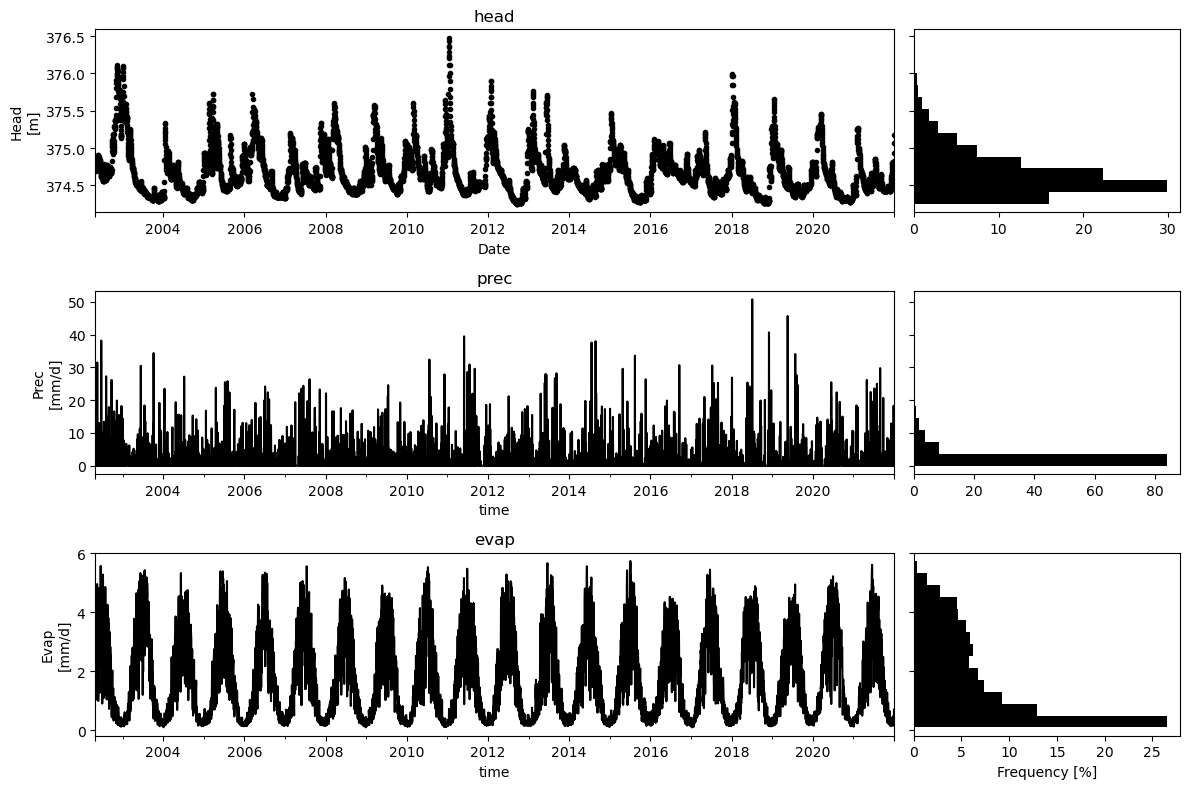

In [6]:
axes = ps.plots.series(
        head=head,
        stresses=[prec, evap],
        tmin=tmin_cal,
        tmax = tmax_val,
        labels=["Head\n[m]", "Prec\n[mm/d]", "Evap\n[mm/d]"],
        figsize = (12, 8))

Validation of imported datasets. This is done to make sure they meet the requirements to be used in PASTAS models.

In [7]:
ps.validate_oseries(head)
ps.validate_stress(prec)
ps.validate_stress(evap)

True

Model is built, a non linear model is chosen, out of all the possible combinations, a recharge FlexModel is chosen with a DoubleEExponential response function.\
A noisemodel is added.

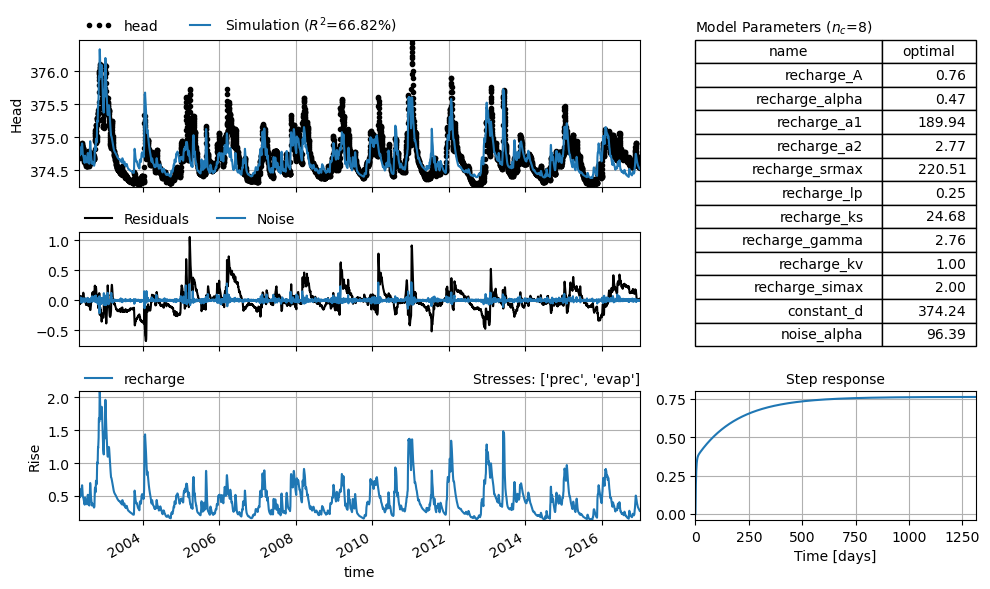

In [8]:
ml = ps.Model(head)
ml.add_noisemodel(ps.ArNoiseModel())

rch = ps.rch.FlexModel()
func = ps.DoubleExponential()
sm = ps.RechargeModel(
    prec,
    evap,
    rfunc = func,
    recharge=rch,
    settings=("prec", "evap"),
)
ml.add_stressmodel(sm)

ml.solve(report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

The resulting fit is not satisfactory yet, the parameters are therefore visualized to identify possible changes that may increase the fit.

In [9]:
ml.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
recharge_A,0.851036,0.00000,85.103621,True,recharge,uniform,0.169952,0.763270
recharge_alpha,0.100000,0.01000,0.990000,True,recharge,uniform,0.102094,0.468671
recharge_a1,10.000000,0.01000,5000.000000,True,recharge,uniform,96.301396,189.938466
recharge_a2,10.000000,0.01000,5000.000000,True,recharge,uniform,0.101000,2.766707
recharge_srmax,250.000000,0.00001,1000.000000,True,recharge,uniform,25.183560,220.508247
recharge_lp,0.250000,0.00001,1.000000,False,recharge,uniform,NaN,0.250000
recharge_ks,100.000000,0.00001,10000.000000,True,recharge,uniform,7.451857,24.677829
recharge_gamma,2.000000,0.00001,20.000000,True,recharge,uniform,0.097605,2.756310
recharge_kv,1.000000,0.25000,2.000000,False,recharge,uniform,NaN,1.000000
recharge_simax,2.000000,0.00000,10.000000,False,recharge,uniform,NaN,2.000000


The parameters which initial values are the furthest from the optimal value are detected and initialized with a closer value. This strategy seems to work, the fit has increased from 67% to 77%.

Fit report head                    Fit Statistics
nfev    48                     EVP          76.93
nobs    5359                   R2            0.77
noise   False                  RMSE          0.15
tmin    2002-05-01 00:00:00    AICc     -20245.28
tmax    2016-12-31 00:00:00    BIC      -20192.61
freq    D                      Obj          61.10
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (8 optimized)
                    optimal     initial   vary
recharge_A         0.620716    0.851036   True
recharge_alpha     0.564358    0.100000   True
recharge_a1       66.305608   10.000000   True
recharge_a2        1.298371   10.000000   True
recharge_srmax   896.525802  250.000000   True
recharge_lp        0.250000    0.250000  False
recharge_ks     9999.923178  100.000000   True
recharge_gamma     6.047352    2.000000   True
recharge_kv        1.000000    1.000000  False
recharge_simax     2.000000    2.000000  False
constan

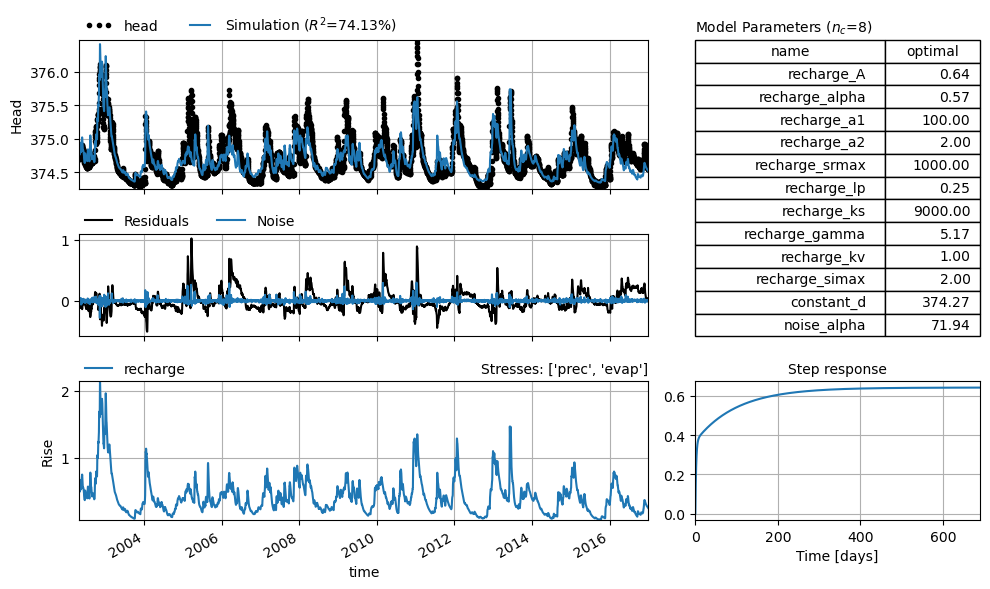

In [10]:
ml.del_noisemodel()

ml.solve(report=True, tmin=tmin_cal, tmax=tmax_cal)

ml.set_parameter(name="recharge_ks", initial=10000, vary=True,
                 pmin=9000, pmax=15000)

ml.set_parameter(name="recharge_A", initial=0.6, vary=True,
                 pmin=0, pmax=1)

ml.set_parameter(name="recharge_alpha", initial=0.5, vary=True,
                 pmin=0, pmax=2)

ml.set_parameter(name="recharge_srmax", initial=800, vary=True,
                 pmin=500, pmax=1000)

ml.set_parameter(name="recharge_a1", initial=66, vary=True,
                 pmin=0, pmax=100)

ml.set_parameter(name="recharge_a2", initial=1, vary=True,
                 pmin=0, pmax=2)

ml.set_parameter(name="recharge_gamma", initial=6, vary=True,
                 pmin=5, pmax=10)


ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial = False, report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

The head are simulated over the total period including the calibration and validation phases. The 95% prediction interval for the model is computed and shown in a plot along with the simulated and observed head values over the validation period.

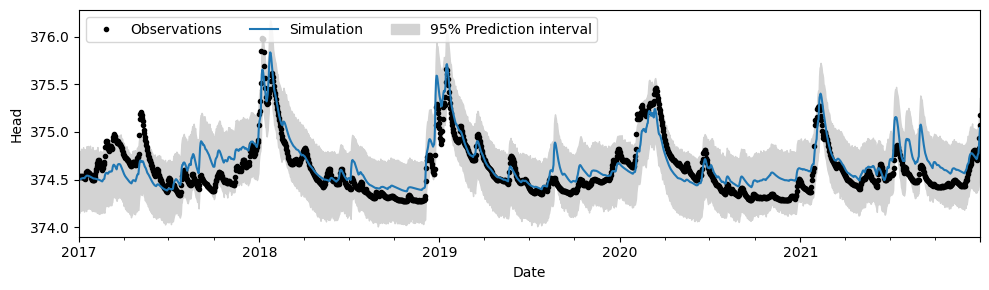

In [11]:
sim_cal = ml.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val = ml.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim = ml.simulate(tmin = tmin_cal, tmax = tmax_val)

ci = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_val, tmax = tmax_val)
ax = ml.plot(figsize=(10, 3), tmin = tmin_val, tmax = tmax_val)
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)

A comprehensive plot is provided including:
- scatter plot of observed head values over the total period (2002 - 2022).
- simulated head over the total period (2002 - 2022).
- 95% prediction interval over the validation period (2017 - 2022).

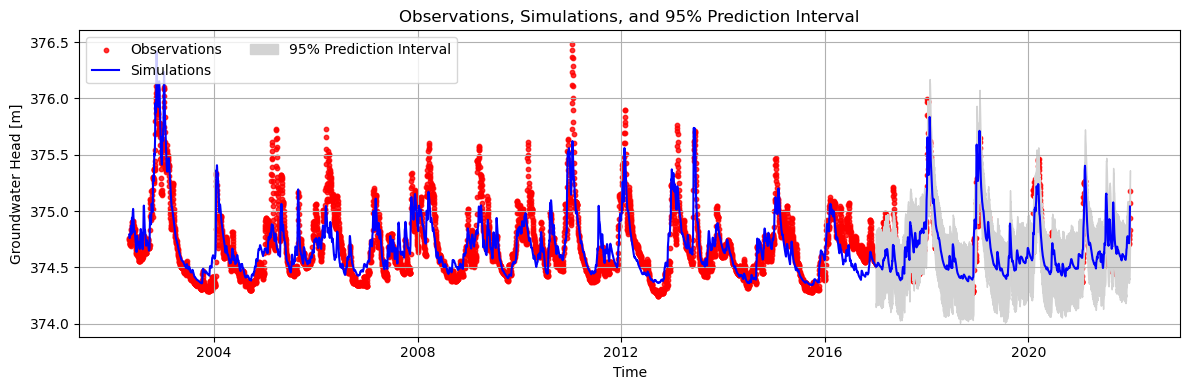

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot observations as scatter points
ax.scatter(
    head.index,
    head,
    label="Observations",
    color="red",
    s=10,  # Size of the scatter points
    alpha=0.8,
)

# Plot simulations as a line
ax.plot(
    heads_sim.index,
    heads_sim,
    label="Simulations",
    color="blue",
    linewidth=1.5,
)

# Add the prediction interval (shaded area)
ax.fill_between(
    ci.index,
    ci.iloc[:, 0],
    ci.iloc[:, 1],
    color="lightgray",
    label="95% Prediction Interval",
)

# Customize the plot
ax.set_title("Observations, Simulations, and 95% Prediction Interval")
ax.set_xlabel("Time")
ax.set_ylabel("Groundwater Head [m]")
ax.legend(loc="upper left", ncol=2)
ax.grid()

plt.show()

**Diagnostics Checking**

A diagnostics check is performed on the noise series of the model. This is done to ensure that the model adequately describes the observed time series.

The check is conducted to test the assumptions for white noise:
- No significant autocorrelation;
- Residuals are homoscedastic;
- Residuals follow a normal distribution.

The results of the diagnostics check show that all tests reject the null hypothesis, meaning that the data do not agree with the assumptions.

In [13]:
ml.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0 ($\alpha$=0.05)
Shapiroo,Normality,0.74,0.00,True
D'Agostino,Normality,3855.43,0.00,True
Runs test,Autocorr.,-24.74,0.00,True
Ljung-Box,Autocorr.,3960.25,0.00,True
Durbin-Watson,Autocorr.,0.67,nan,False


**Reducing autocorrelation**

Autocorrelation is computed and displayed for time lags from 1 to 365 days. The autocorrelation plot shows that autocorrelation decreases continuously with increasing time lags.

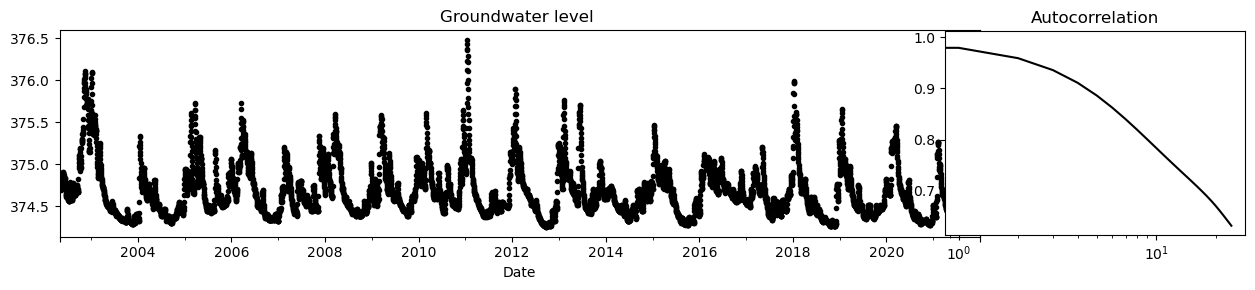

In [14]:
ax = head.plot(figsize=(10, 3), marker=".", linestyle=" ", color="k")
ax1 = plt.axes([0.95, 0.2, 0.3, 0.68])
acf = ps.stats.acf(
    head,
    lags=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        12,
        13,
        14,
        30,
        61,
        90,
        120,
        150,
        180,
        210,
        240,
        270,
        300,
        330,
        365,
    ],
).values
ax1.semilogx(acf, color="k") 
ax.set_title("Groundwater level ")
ax1.set_title("Autocorrelation");

The code below performs an analysis to investigate the effect of varying temporal resolution. It creates and solves multiple models, each with a different level of temporal aggregation in the input time series.

1. **Initialization**:
   - `mls_ar`: An empty dictionary to store solved models.
   - `dts`: Range of temporal resolution steps to test.

2. **Model iteration**:
   - The loop iterates over `dt`, creating **10 models** in total.
   - For each `dt`, the groundwater head time series (`head`) is downsampled using `head.iloc[::dt]`, resulting in progressively longer time intervals between observations.

3. **Model setup**:
   - A model is created for each `dt`.
   - A noise model (`ps.ArNoiseModel`) is added.
   - A recharge model (`ps.RechargeModel`) is configured as above:
     - **Inputs**: Precipitation (`prec`) and evaporation (`evap`).
     - **Functions**: `FlexModel()` for recharge and `DoubleExponential()` for response.

4. **Parameter initialization**:
   - Parameters for the recharge model are initialized as above.

5. **Model calibration**:
   - Each model is solved over the defined calibration period (`tmin_cal` to `tmax_cal`) to fit the parameters to the input data.

6. **Model storage**:
   - Solved models are stored in the dictionary `mls_ar` with names that include the temporal resolution (`Germany_{dt}`).
   
Output:
- **10 solved models** stored in `mls_ar`.
- Each model represents a different temporal resolution, with intervals between observations increasing according to the sequence of `dt` values: 1, 3, 5, ..., 19.


In [15]:
mls_ar = {}
dts = 21

# Model settings: Only Nonlinear model configuration
rfunc = ps.DoubleExponential()
rch = ps.rch.FlexModel()

for dt in range(1, dts, 2):
    # Create the basic Pastas model
    ml_name = f"Germany_{dt}"
    ml = ps.Model(head.iloc[::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())

    
    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    
    ml.set_parameter(name="rch_ks", initial=10000, vary=True,
                 pmin=9000, pmax=15000)

    ml.set_parameter(name="rch_A", initial=0.6, vary=True,
                 pmin=0, pmax=1)

    ml.set_parameter(name="rch_alpha", initial=0.5, vary=True,
                 pmin=0, pmax=2)

    ml.set_parameter(name="rch_srmax", initial=800, vary=True,
                 pmin=500, pmax=1000)

    ml.set_parameter(name="rch_a1", initial=66, vary=True,
                 pmin=0, pmax=100)

    ml.set_parameter(name="rch_a2", initial=1, vary=True,
                 pmin=0, pmax=2)

    ml.set_parameter(name="rch_gamma", initial=6, vary=True,
                 pmin=5, pmax=10)

    # Solve the model
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_ar[ml_name] = ml

The previously created groundwater models (`mls_ar`) are changed to analyze the impact of changing the noise model from autoregressive (AR) to autoregressive-moving-average (ARMA). The modified models are then calibrated and stored for comparison.

Outputs:
- Recalibrated models stored in `mls_arma`.
- Each model is identical to the one in `mls_ar`, except for the noise model type (ARMA instead of AR).

--> a decision can be made about the type of noise model to use.

In [16]:
mls_arma = {}

for ml_name, ml in mls_ar.items():
    ml = ml.copy(name=ml.name)

    
    ml.del_noisemodel()
    ml.add_noisemodel(ps.ArmaNoiseModel())

    
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_arma[ml_name] = ml

The performance of different noise models (AR and ARMA) is evaluated by computing the Durbin-Watson (DW) statistic. The results are plotted to compare the two noise models at varying temporal resolutions (`dt`).

1. **Data preparation**
- Two empty DataFrames (`data` and `data2`) are initialized to store the DW statistic for each temporal resolution (`dt`) and noise model.

2. **Compute DW statistic for AR noise models**
- Loop through all models in `mls_ar` (models with AR noise):
  - Extract the temporal resolution `i` from the model name.
  - Retrieve the noise component (`ml.noise`) for the calibration period (`tmin_cal` to `tmax_val`).

3. **DW statistic for ARMA noise models**
- Loop through all models in `mls_arma` (models with ARMA noise):
  - Perform the same steps as for AR noise models, storing the DW statistic in `data2`.

4. **Results**
- Two subplots (`ax1` and `ax2`) for AR and ARMA noise models are created, respectively:
  - **AR(1) Noise Model**:
    - Plot of DW statistics from `data` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.
  - **ARMA(1,1) Noise Model**:
    - Plot pf DW statistics from `data2` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.


The Durbin-Watson statistic is used as the metric:
- **DW = 2.0**: Indicates no autocorrelation.
- **DW < 2.0**: Indicates positive autocorrelation.

Outputs:
- **Two plots** comparing DW statistics for AR(1) and ARMA(1,1) noise models.
- Visual comparison of how the two noise models handle residual autocorrelation across varying temporal resolutions.

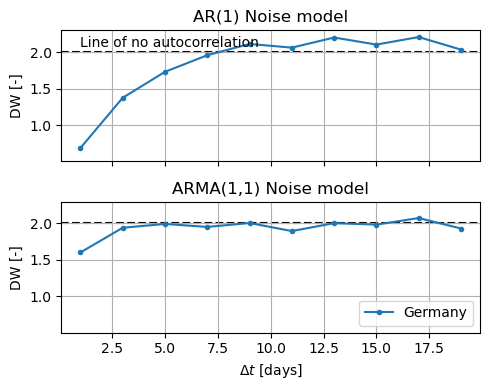

In [17]:
data = pd.DataFrame(index=range(dt, 1), columns=["Germany"])

for ml in mls_ar.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

data2 = pd.DataFrame(index=range(dt, 1), columns=["Germany"])

for ml in mls_arma.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data2.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

# Plot the results
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(5, 4), sharey=True)

# AR1 Model
data.plot(ax=ax1, marker=".", legend=False)
ax1.set_ylabel("DW [-]")
ax1.axhline(2.0, c="k", linestyle="--", zorder=-1)
ax1.text(1, 2.07, "Line of no autocorrelation")
ax1.grid()
ax1.set_title("AR(1) Noise model")

# ArmaModel
data2.plot(ax=ax2, marker=".", legend=False)
ax2.set_ylabel("DW [-]")
ax2.set_yticks([1, 1.5, 2.0])
ax2.axhline(2.0, c="k", linestyle="--", zorder=-10)
ax2.set_ylim(0.5, 2.3)
ax2.grid()
ax2.legend(ncol=3, loc=4)
ax2.set_xlabel("$\\Delta t$ [days]")
ax2.set_title("ARMA(1,1) Noise model")
plt.tight_layout()

The data is split into segments starting at different offsets (`start`), multiple models are created and solved, storing the results.

1. **Initialization**:
- `mls`: An empty dictionary to store solved models.
- `dt = 5`: Defines the temporal resolution or step size for input data segmentation, chosen based on the previous plots.
- Recharge and response functions:
  - `rfunc`: `DoubleExponential()` for modeling the aquifer response.
  - `rch`: `FlexModel()` for modeling nonlinear recharge dynamics.

2. **Models creation**:
- Loops over starting offsets (`start`) from `0` to `dt - 1` (5 iterations):
  - Creates distinct models by slicing the `head` time series with an offset:
    ```python
    head.iloc[start::dt]
    ```
    This creates sub-series where each model begins at a different temporal offset and uses every `dt`-th observation.

3. **Model configuration**:
- A recharge model (`ps.RechargeModel`) is added to simulate groundwater recharge using the same settings as above.
- Parameters are initialized as above.



5. **Noise model**:
- An ARMA noise model (`ps.ArmaNoiseModel()`) is added.

6. **Model calibration**:
- Each model is solved over the defined calibration period (`tmin_cal` to `tmax_cal`).



Output:
- **5 calibrated models**, each representing a different temporal offset.
  - X-axis: Observation indices adjusted by `start`.
  - Y-axis: Observed and simulated groundwater head.
- Models are stored in the `mls` dictionary, with keys like `Germany_1`, `Germany_2`, etc., corresponding to the starting offsets.


In [18]:
mls = {}
dt = 5


rfunc = ps.DoubleExponential()
rch = ps.rch.FlexModel()

for start in range(0, dt, 1):
    ml_name = f"Germany_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)
    # Add the recharge model
    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    # Set parameters for the Nonlinear model
    ml.set_parameter(name="rch_ks", initial=10000, vary=True,
         pmin=9000, pmax=15000)

    ml.set_parameter(name="rch_A", initial=0.6, vary=True,
                 pmin=0, pmax=1)

    ml.set_parameter(name="rch_alpha", initial=0.5, vary=True,
                 pmin=0, pmax=2)

    ml.set_parameter(name="rch_srmax", initial=800, vary=True,
                 pmin=500, pmax=1000)

    ml.set_parameter(name="rch_a1", initial=66, vary=True,
                 pmin=0, pmax=100)

    ml.set_parameter(name="rch_a2", initial=1, vary=True,
                 pmin=0, pmax=2)

    ml.set_parameter(name="rch_gamma", initial=6, vary=True,
                 pmin=5, pmax=10)

    
    ml.add_noisemodel(ps.ArmaNoiseModel())
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls[ml_name] = ml

In this code cell the parameter estimates and uncertainties are organized in `df`.

In [19]:
data = {}

name = "Germany"
ml = mls["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]
        # df.loc[:, (slice(None), "std")] *=  1.96

df = pd.concat(data, axis=1)

In [20]:
ml.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
rch_A,0.600000,0.000000e+00,1.0,True,rch,uniform,0.049357,0.655687
rch_alpha,0.500000,0.000000e+00,2.0,True,rch,uniform,0.047705,0.518784
rch_a1,66.000000,0.000000e+00,100.0,True,rch,uniform,21.282797,86.504894
rch_a2,1.000000,0.000000e+00,2.0,True,rch,uniform,0.162842,2.000000
rch_srmax,800.000000,5.000000e+02,1000.0,True,rch,uniform,133.366193,778.291587
rch_lp,0.250000,1.000000e-05,1.0,False,rch,uniform,NaN,0.250000
rch_ks,10000.000000,9.000000e+03,15000.0,True,rch,uniform,12347.316242,9000.008608
rch_gamma,6.000000,5.000000e+00,10.0,True,rch,uniform,0.667529,5.590485
rch_kv,1.000000,2.500000e-01,2.0,False,rch,uniform,NaN,1.000000
rch_simax,2.000000,0.000000e+00,10.0,False,rch,uniform,NaN,2.000000


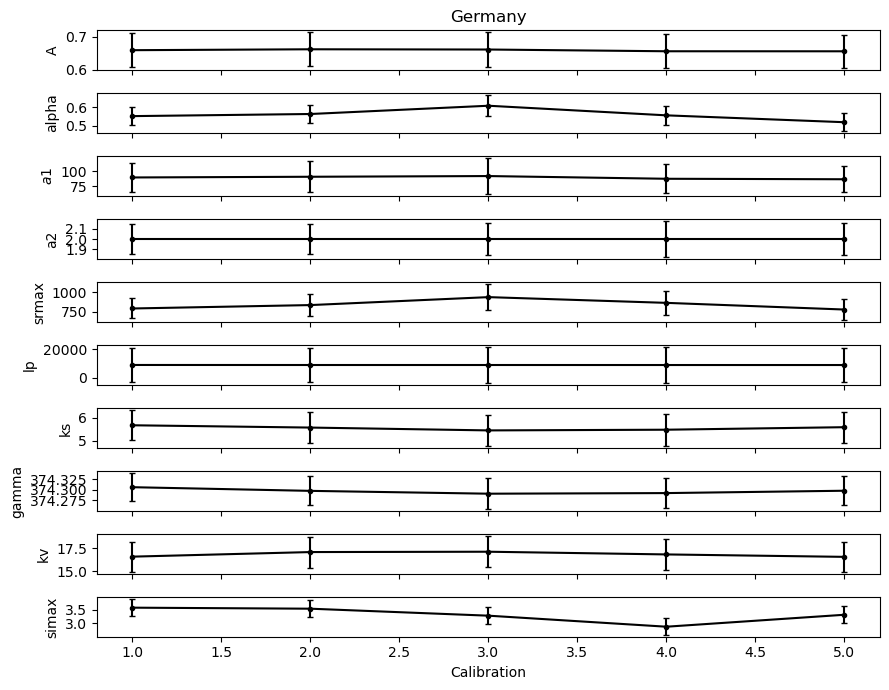

In [21]:


fig, axes = plt.subplots(10, 1, sharex=True, figsize=(9, 7))
axes = axes.flatten()

kwargs = dict(legend=False, color="0", capsize=2, linestyle="-", marker=".")

labels = ["A", "alpha", "$a1$", "a2", "srmax", "lp", "ks", "gamma", "kv", "simax", "constant_d", "noise_alpha", "noise_beta"]


axes[0].set_title("Germany")
for i, par in enumerate(df["Germany"].columns.get_level_values(0).unique()):
    df.xs(("Germany", par), axis=1, level=[0, 1]).plot(
        ax=axes[i], yerr="std", **kwargs
    )
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Calibration")

plt.tight_layout()


The statistical diagnostics of the previously calibrated groundwater models stored in the `mls` dictionary is performed.

In [22]:
for name, model in mls.items():
    print(f"Model name: {name}")
    print(model.stats.diagnostics(alpha=0.05))

Model name: Germany_1
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.77    0.00                       True
D'Agostino     Normality    788.65    0.00                       True
Runs test      Autocorr.     -3.73    0.00                       True
Ljung-Box      Autocorr.      4.72    0.03                       True
Durbin-Watson  Autocorr.      2.03     nan                      False
Model name: Germany_2
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.77    0.00                       True
D'Agostino     Normality    732.84    0.00                       True
Runs test      Autocorr.     -3.97    0.00                       True
Ljung-Box      Autocorr.      3.39    0.07                      False
Durbin-Watson  Autocorr.      2.03     nan                      False
Model name: Germany_3
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality

Autocorrelation is visually inspected and a Stoffer-Toloi check is computed, both showing positive results, there is no significant autocorrelation.

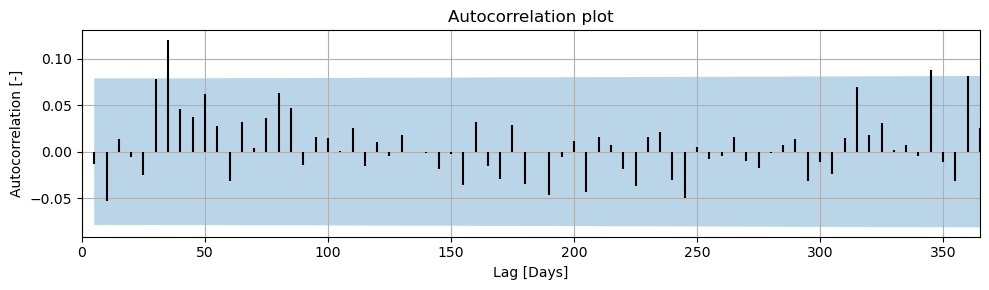

In [23]:
model = mls["Germany_2"]
noise = model.noise()
ax = ps.plots.acf(noise, acf_options=dict(bin_width=0.5), figsize=(10, 3), alpha=0.01)

In [24]:
stat, p = ps.stats.stoffer_toloi(noise, lags=5)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, no significant autocorrelation. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.54


**Normality Checking**

Normality is checked visually by looking at the probability plot and at the histogram of he residuals with a normal distribution fit to it.

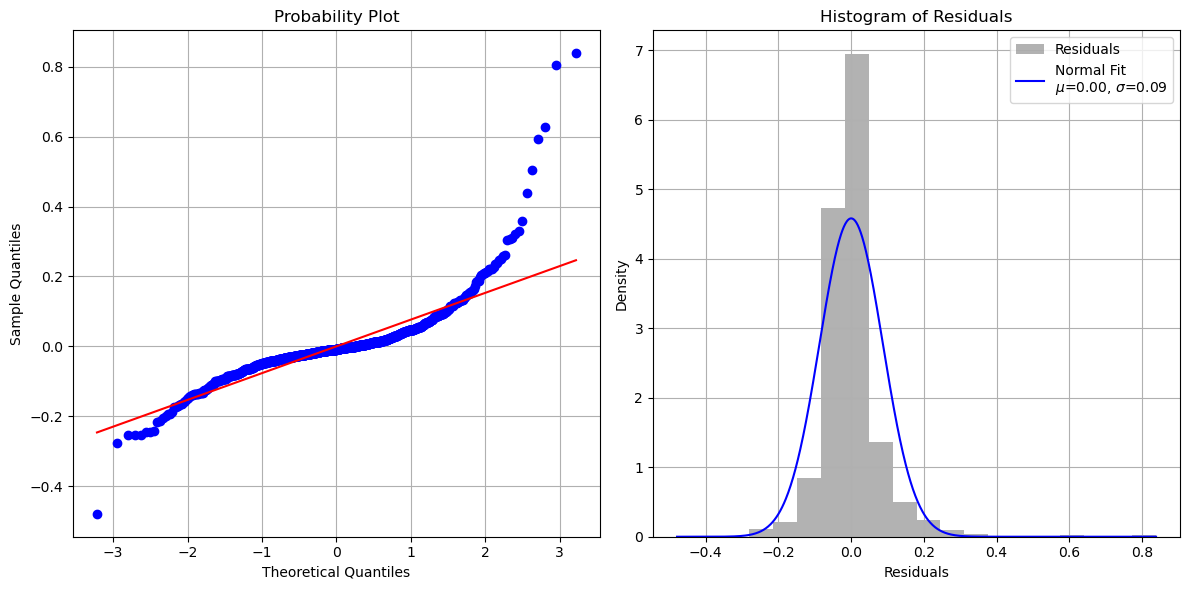

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


stats.probplot(noise, dist="norm", plot=axes[0])
axes[0].set_title("Probability Plot")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")
axes[0].grid()

axes[1].hist(noise, bins=20, density=True, alpha=0.6, color="gray", label="Residuals")


mu, std = stats.norm.fit(noise)
x = np.linspace(min(noise), max(noise), 1000)
pdf = stats.norm.pdf(x, loc=mu, scale=std)
axes[1].plot(x, pdf, color="blue", label=f"Normal Fit\n$\mu$={mu:.2f}, $\sigma$={std:.2f}")
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [26]:
stat, p = stats.normaltest(noise)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0


**Homoscedasticity Checking**

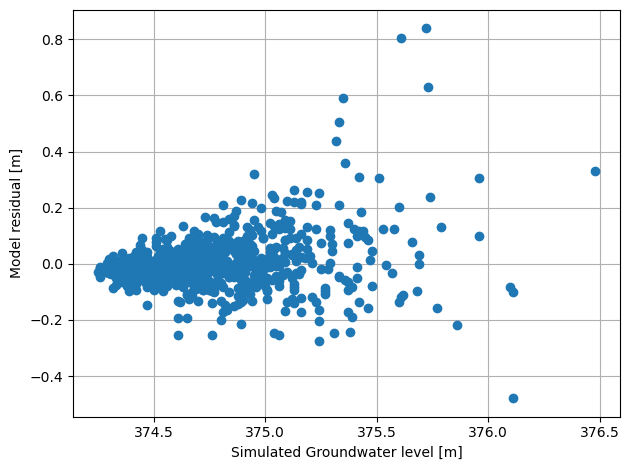

In [27]:
plt.plot(model.observations(), model.noise(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]")
plt.grid()

The performance of the model is assessed using two different metrics, as requested from the groundwater challenge.  
The metrics applied are:
- Nash-Sutcliffe Efficiency (NSE) over the two periods;
- Mean Absolute Error (MAE) over heads value below the 0.2 quantile and above the 0.8 quantile for both calibration and validation periods.  

The results show better fit in the calibration period, with better representation of low end values.

In [28]:
nse_cal = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal)
nse_val = ps.stats.metrics.nse(obs = head_val, sim = sim_val)

q02_obs_cal = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal = sim_cal.loc[q02_obs_cal.index]

q02_obs_val = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val = sim_val.loc[q02_obs_val.index]

q08_obs_cal = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal = sim_cal.loc[q08_obs_cal.index]

q08_obs_val = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val = sim_val.loc[q08_obs_val.index]

mae_cal02 = ps.stats.metrics.mae(obs = q02_obs_cal, sim = q02_sim_cal)
mae_cal08 = ps.stats.metrics.mae(obs = q08_obs_cal, sim = q08_sim_cal)

mae_val02 = ps.stats.metrics.mae(obs = q02_obs_val, sim = q02_sim_val)
mae_val08 = ps.stats.metrics.mae(obs = q08_obs_val, sim = q08_sim_val)


print(f"Results of fit test:\n"
      f"  - NSE over calibration period: {nse_cal:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08:.4f}.\n")

Results of fit test:
  - NSE over calibration period: 0.7413.
  - MAE_02 over calibration period: 0.0823.
  - MAE_08 over calibration period: 0.0937.

  - NSE over validation period: 0.6555.
  - MAE_02 over validation period: 0.1310.
  - MAE_08 over validation period: 0.1238.



The quality of the 95% prediction interval is tested by computing the Prediction Interval Coverage Probability (PICP) to assess the share of values falling the wanted interval.  
The computed PICP is higher that 95% showing a slight overestimation of the uncertainty. 

In [29]:
low = ci.iloc[:, 0].reindex(head_val.index)
up = ci.iloc[:, 1].reindex(head_val.index)

within = head_val[(head_val >= low) & (head_val <= up)]

PICP = len(within)/len(low)*100
print(f"The computed PICP is: {PICP:.3f} %")

The computed PICP is: 96.112 %
